# 필요한 라이브러리 로드

In [ ]:
import numpy as np
import pandas as pd
import urllib.request
import json
from pandas import json_normalize
from urllib.parse import urlencode, quote_plus, unquote

# 파일 로드


In [ ]:
# 사용할 Association Rules CSV 로드
asso_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DM2302/Project/Result_Asso.csv")
asso_df = asso_df.drop('Unnamed: 0', axis=1)

In [ ]:
# 사용할 Clustering PKL 로드
data_cluster = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/DM2302/Project/game_feature_matrix.pkl")
data_cluster = data_cluster.reset_index()

# 추천을 받고 싶은 사용자가 보유한 게임 크롤링

In [ ]:
import urllib.request
import json
from pandas import json_normalize
from urllib.parse import urlencode, quote_plus, unquote

In [ ]:
# 추천을 받고 싶어하는 사용자
user_to_scan = 76561198143460429

In [ ]:
api_link = 'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/'
api_key = '...'
steamid = '76561198003081163' # 스트리머 우왁굳
queryParams = '?' + urlencode({quote_plus('key') : api_key,
                               quote_plus('steamid') : steamid,
                               quote_plus('relationship') : 'friend'
                               })
url = api_link + queryParams

In [ ]:
# 해당 사용자의 게임 플레이 목록 초기화
played_game_list = []

# 쿼리 준비
queryParams = '?' + urlencode({quote_plus('key') : api_key,
                              quote_plus('steamid') : user_to_scan,
                              quote_plus('include_played_free_games') : 1,
                              quote_plus('format') : 'json'
                              })
url = api_link + queryParams

# 데이터를 요청하고 변환 : 스캔한 사용자 프로필이 Public이 아닌 경우 401 에러에 대한 예외 처리
try:
    text = urllib.request.urlopen(url).read().decode('utf-8')
except:
    text = '{}'
json_return = json.loads(text)

# 데이터 해석 작업
if json_return.get('response') != {}:

    # 해당 유저의 게임 목록 가져오기
    owned_game_list = json_return.get('response').get('games')
    # 유효한 게임만 관련 정보 가져오기
    for game in owned_game_list:
        game_info = {}
        if game.get('playtime_forever') < 121:
            continue
        played_game_list.append(game.get('appid'))

In [ ]:
print(played_game_list)

[4000, 550, 105600, 49520, 251570, 108600, 271590, 285900, 286160, 304930, 356670, 361420, 322330, 381210, 386940, 413150, 239140, 431960, 433340, 438100, 477160, 527230, 578080, 648800, 648120, 218620, 658850, 665360, 466240, 739630, 774861, 880940, 897450, 962130, 1049590, 1172470, 1217060, 359550, 1377380, 1404210, 1426210, 1469280, 1478220, 843380, 1531430, 1568590, 1621690, 924970, 1726190, 1794680]


# 클러스터를 통한 동일 클러스터 내 매칭 추천

In [ ]:
# 추천을 받고 싶어하는 사용자의 게임
# ...... 단, 게임 목록은 사용자 주관에 따르나, 가능한 플레이 타임 2시간 이상으로 추천

want_recommend_games = [281990, 1049590, 1158310, 294100, 1172470]
if played_game_list is not []:
    want_recommend_games = played_game_list

In [ ]:
from collections import Counter

# 클러스터 변환 예시
recommend_cluster = []
for game in want_recommend_games:
    if not data_cluster[data_cluster['GameID'] == str(game)]['cluster'].empty:
        recommend_cluster.append(data_cluster[data_cluster['GameID'] == str(game)]['cluster'].values[0])

def find_mode(lst):
    # 빈 리스트일 경우 예외 처리
    if not lst:
        return []

    # 각 원소의 빈도를 계산
    counts = Counter(lst)
    # 빈도수가 가장 큰 값 찾기
    max_count = max(counts.values())
    # 최빈값(들) 찾기
    modes = [key for key, value in counts.items() if value == max_count]

    return modes

print(find_mode(recommend_cluster))

[4]


In [ ]:
# 추천 알고리즘
#  1. 먼저 사용자가 제출한 게임 목록의 클러스터 확인
#  2. 동일 클러스터 내의 게임으로 AR 필터링
#  3. 보유 게임이 포함된 Row만 살려서 상위 Lift 순으로 추천

filtered_df = asso_df
df_con = pd.DataFrame(columns=['antecedent', 'consequent', 'confidence', 'lift', 'support'])
df_con2 = pd.DataFrame(columns=['antecedent', 'consequent', 'confidence', 'lift', 'support'])
df_ant = pd.DataFrame(columns=['antecedent', 'consequent', 'confidence', 'lift', 'support'])

recommend_cluster = []
for game in want_recommend_games:
    if not data_cluster[data_cluster['GameID'] == str(game)]['cluster'].empty:
        recommend_cluster.append(data_cluster[data_cluster['GameID'] == str(game)]['cluster'].values[0])
recommend_cluster = find_mode(recommend_cluster)

for i in range(len(asso_df['consequent'])):
    con_cell = json.loads(asso_df['consequent'][i])
    for j in range(len(con_cell)):
        result_row = data_cluster.loc[data_cluster['GameID'] == str(con_cell[j])]
        if not result_row.empty:
            if result_row['cluster'].values[0] in recommend_cluster:
                drop_row = asso_df.loc[i].to_frame().T
                df_con = pd.concat([df_con, drop_row])

for i in range(len(df_con['consequent'])):
    con_cell = json.loads(df_con['consequent'].values[i])
    for j in range(len(con_cell)):
        result_row = data_cluster.loc[data_cluster['GameID'] == str(con_cell[j])]
        if not result_row.empty:
            if result_row['cluster'].values[0] in played_game_list:
                drop_row = df_con.loc[i].to_frame().T
                df_con2 = pd.concat([df_con, drop_row])

for i in range(len(df_con['antecedent'])):
    match_count = 0
    con_cell = json.loads(df_con['antecedent'].values[i])
    for j in range(len(con_cell)):
        result_row = data_cluster[data_cluster['GameID'] == con_cell[j]]
        if not result_row.empty:
            if result_row['cluster'].values[0] in played_game_list:
                match_count = match_count + 1
                continue
    if match_count != 0:
        drop_row = df_con.loc[i].to_frame().T
        df_ant = pd.concat([df_con, drop_row])

df_output = pd.merge(df_ant, df_con2)

In [ ]:
df_con.info()
df_con.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4352 entries, 1 to 11987
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   antecedent  4352 non-null   object
 1   consequent  4352 non-null   object
 2   confidence  4352 non-null   object
 3   lift        4352 non-null   object
 4   support     4352 non-null   object
dtypes: object(5)
memory usage: 204.0+ KB


,antecedent,consequent,confidence,lift,support
1,[548430],[440],0.711538,1.50894,0.109046
5,[548430],[578080],0.568047,1.144658,0.087055
9,[548430],[730],0.778107,1.026998,0.119247
10,"[227300, 730]",[440],0.579976,1.229939,0.107685
13,"[227300, 730]",[578080],0.600733,1.210521,0.111539
18,"[304930, 4000, 550, 730]",[440],0.851986,1.806783,0.107005
19,"[304930, 4000, 550, 730]",[578080],0.649819,1.309435,0.081614
21,"[286160, 578080]",[730],0.819599,1.081763,0.083428
24,[648800],[440],0.564067,1.196201,0.091816
28,[648800],[578080],0.68663,1.38361,0.111766


In [ ]:
df_con.sort_values(by='lift' ,ascending=False).head(10)

,antecedent,consequent,confidence,lift,support
4054,[200510],[268500],0.655052,4.799727,0.085241
9115,"[289070, 440]",[8930],0.763948,3.003366,0.080707
332,"[289070, 218620]",[8930],0.731076,2.874131,0.083201
7077,"[289070, 550]",[8930],0.729008,2.866001,0.086602
4059,[200510],[8930],0.728223,2.862916,0.094763
1748,[212680],[8930],0.72147,2.836367,0.084561
9623,"[8930, 218620]",[289070],0.540501,2.788478,0.083201
2415,"[289070, 730]",[8930],0.673435,2.647523,0.090229
3903,"[8930, 550]",[289070],0.507979,2.620695,0.086602
431,[268500],[8930],0.666113,2.618738,0.090909


# 파일 로드 및 DataFrame 작업

In [ ]:
# JSON 로드
with open('/content/drive/MyDrive/Colab Notebooks/DM2302/Project/UsersGamesData.json', 'r', encoding='utf-8') as file_a:
    json_file = json.load(file_a)

In [ ]:
# JSON 데이터를 DataFrame 형태로 변환
# DF 구조체 초기화
pre_df = []

# 추출 작업 시작
for user, game_list in json_file.items():
    for game in game_list:
        if game['playtime_forever'] > 120:  # 플레이타임이 2시간 이상인 게임만을 대상으로
            pre_df.append([user, game['appid'], game['playtime_forever']])  # 사용자 ID, 게임 ID, 플레이타임 기록

# DataFrame 조작 및 통계치 확인

In [ ]:
df = pd.DataFrame(pre_df)
df.columns = ['UserID', 'GameID', 'PlayTime']
df.head()

,UserID,GameID,PlayTime
0,76561199029457670,10,48281
1,76561199029457670,240,737
2,76561199029457670,17390,147
3,76561199029457670,550,355
4,76561199029457670,230410,245


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653374 entries, 0 to 653373
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   UserID    653374 non-null  object
 1   GameID    653374 non-null  int64 
 2   PlayTime  653374 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 15.0+ MB


In [ ]:
df.describe(include='all')

,UserID,GameID,PlayTime
count,653374,6.533740e+05,6.533740e+05
unique,4411,NaN,NaN
top,76561198102767019,NaN,NaN
freq,7342,NaN,NaN
mean,NaN,4.771690e+05,2.676748e+03
std,NaN,3.824186e+05,1.844596e+04
min,NaN,1.000000e+01,1.210000e+02
25%,NaN,2.518500e+05,2.090000e+02
50%,NaN,3.771600e+05,3.140000e+02
75%,NaN,5.759400e+05,8.170000e+02


In [ ]:
df['UserID'].value_counts()

76561198102767019    7342
76561197968410781    7298
76561198264362271    6566
76561198150396857    6328
76561198032550800    5800
                     ... 
76561198992662761       1
76561198259075441       1
76561198364449275       1
76561199195911941       1
76561198965862097       1
Name: UserID, Length: 4411, dtype: int64

In [ ]:
df['GameID'].value_counts()

730        3342
578080     2189
440        2080
550        2056
218620     1820
           ... 
2287970       1
2432110       1
1608270       1
2306740       1
702700        1
Name: GameID, Length: 20245, dtype: int64

<ipython-input-9-72fb8f8f3824>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_series = pd.Series([])


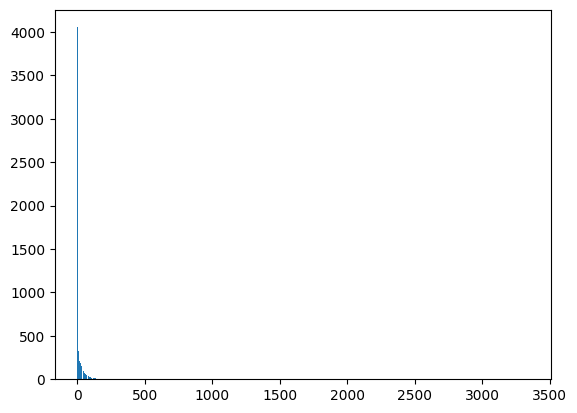

In [ ]:
import matplotlib.pyplot as plt

new_series = pd.Series([])

plt_df = df['GameID'].value_counts()
i = 0
for value in plt_df.values:
    new_series[i] = value
    i = i + 1
plt_df = new_series

plt.bar(plt_df.value_counts().index, plt_df.value_counts().values)
plt.show()

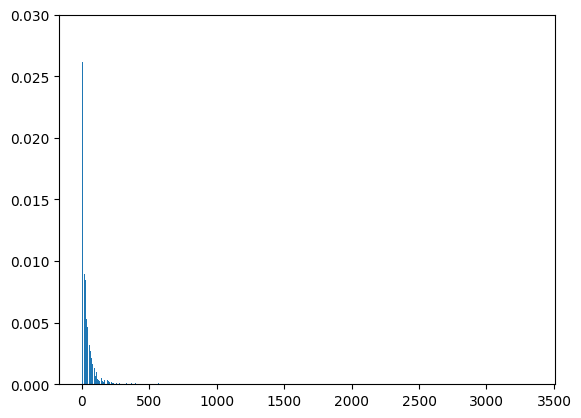

In [ ]:
plt.bar(plt_df.value_counts().index, plt_df.value_counts().values / 20245)
plt.ylim(0, 0.03)
plt.show()

# Spark와 FP-Growth 적용

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
py_df = spark.createDataFrame(df)

In [ ]:
# CSV에서 DF 불러오는 경우
py_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/DM2302/Project/id_premitive.csv', header=True, inferSchema=True)
py_df = py_df.drop('_c0')

In [ ]:
py_df.printSchema()
py_df.show(10)

root
 |-- UserID: string (nullable = true)
 |-- GameID: long (nullable = true)
 |-- PlayTime: long (nullable = true)

+-----------------+------+--------+
|           UserID|GameID|PlayTime|
+-----------------+------+--------+
|76561199029457670|    10|   48281|
|76561199029457670|   240|     737|
|76561199029457670| 17390|     147|
|76561199029457670|   550|     355|
|76561199029457670|230410|     245|
|76561199029457670|252950|     321|
|76561199029457670|257750|     780|
|76561199029457670|   730|   70374|
|76561199029457670|322330|     315|
|76561199029457670|386940|    1445|
+-----------------+------+--------+
only showing top 10 rows



In [ ]:
data_grouped = py_df.groupBy("UserID").agg(collect_set('GameID').alias('GamesID'))

In [ ]:
data_grouped.printSchema()
data_grouped.show(10)

root
 |-- UserID: string (nullable = true)
 |-- GamesID: array (nullable = false)
 |    |-- element: long (containsNull = false)

+-----------------+--------------------+
|           UserID|             GamesID|
+-----------------+--------------------+
|76561197960272730|[555160, 221380, ...|
|76561197960287391|[257850, 17300, 8...|
|76561197960308352|[260790, 42700, 7...|
|76561197960309472|[223470, 204450, ...|
|76561197960767217|[110800, 251150, ...|
|76561197961524908|[244210, 24240, 2...|
|76561197961654602|[253030, 34330, 2...|
|76561197961658650|[1938090, 230410,...|
|76561197961688673|[34330, 1142710, ...|
|76561197961861494|[381210, 730, 369...|
+-----------------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.fpm import FPGrowth
fpGrowth = FPGrowth(itemsCol="GamesID", minSupport=0.08, minConfidence=0.5)
model = fpGrowth.fit(data_grouped)

In [ ]:
freq_01 = model.freqItemsets
asso_01 = model.associationRules
print(f"Count of frequent itemsets: {freq_01.count()}\nCount of association rules: {asso_01.count()}\n")
freq_01.sort(desc('freq')).show()
asso_01.sort(desc('lift')).show()

Count of frequent itemsets: 5161
Count of association rules: 11988

+-------------+----+
|        items|freq|
+-------------+----+
|        [730]|3342|
|     [578080]|2189|
|        [440]|2080|
|        [550]|2056|
|     [218620]|1820|
|[578080, 730]|1812|
|       [4000]|1775|
|   [440, 730]|1757|
|     [271590]|1723|
|        [570]|1658|
|   [550, 730]|1638|
|[218620, 730]|1583|
|  [4000, 730]|1578|
|     [105600]|1565|
|     [945360]|1529|
|     [359550]|1511|
|     [431960]|1476|
|        [620]|1466|
|[271590, 730]|1446|
|   [550, 440]|1358|
+-------------+----+
only showing top 20 rows

+--------------------+----------+------------------+------------------+-------------------+
|          antecedent|consequent|        confidence|              lift|            support|
+--------------------+----------+------------------+------------------+-------------------+
|            [268500]|  [200510]|0.6245847176079734|4.7997268107469875|0.08524144184992065|
|            [200510]|  [268500]|0

# AppID - 게임이름 매칭

In [ ]:
# 매칭에 사용할 DB CSV 로드
games_db_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DM2302/Project/SteamGamesDB.csv")

In [ ]:
games_db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83560 entries, 0 to 83559
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       83560 non-null  int64  
 1   Name                        83554 non-null  object 
 2   Release date                83560 non-null  object 
 3   Estimated owners            83560 non-null  object 
 4   Peak CCU                    83560 non-null  int64  
 5   Required age                83560 non-null  int64  
 6   Price                       83560 non-null  float64
 7   DLC count                   83560 non-null  int64  
 8   About the game              80123 non-null  object 
 9   Supported languages         83560 non-null  object 
 10  Full audio languages        83560 non-null  object 
 11  Reviews                     9716 non-null   object 
 12  Header image                83560 non-null  object 
 13  Website                     390

In [ ]:
# FI와 AR 내 게임ID를 게임이름으로 변경

asso_01_pd = df_con.reset_index()

for i in range(len(asso_01_pd['antecedent'])):
    con_cell = json.loads(asso_01_pd['antecedent'][i])
    result_names = []
    for j in range(len(con_cell)):
        result_row = games_db_df[games_db_df['AppID'] == con_cell[j]]
        if not result_row.empty:
            result_name = result_row['Name'].values[0]
            result_names.append(result_name)
    asso_01_pd.loc[i, 'antecedent'] = str(result_names)

for i in range(len(asso_01_pd['consequent'])):
    con_cell = json.loads(asso_01_pd['consequent'][i])
    for j in range(len(con_cell)):
        result_row = games_db_df[games_db_df['AppID'] == con_cell[j]]
        if not result_row.empty:
            result_name = []
            result_name.append(result_row['Name'].values[0])
            asso_01_pd.loc[i, 'consequent'] = str(result_name)

In [ ]:
asso_01_pd.sort_values(by='lift' ,ascending=False).head(10)

,index,antecedent,consequent,confidence,lift,support
83,11624,['DARK SOULS™ III'],['ELDEN RING'],0.538961,3.243325,0.094083
30,4379,['Starbound'],['Stardew Valley'],0.59596,2.71568,0.080254
58,8749,"[""Don't Starve Together"", 'Terraria']",['Stardew Valley'],0.553134,2.520529,0.092043
33,4917,"['Stardew Valley', 'Terraria']","[""Don't Starve Together""]",0.622699,2.472302,0.092043
82,11498,['Middle-earth™: Shadow of Mordor™'],['The Witcher® 3: Wild Hunt'],0.596947,2.465479,0.088642
20,3443,"['The Elder Scrolls V: Skyrim', 'Borderlands 2']",['The Witcher® 3: Wild Hunt'],0.590327,2.43814,0.094083
63,9048,"['Stardew Valley', 'PAYDAY 2']","[""Don't Starve Together""]",0.608547,2.416112,0.080707
31,4380,['Starbound'],"[""Don't Starve Together""]",0.607744,2.412925,0.081841
22,3506,"['The Elder Scrolls V: Skyrim', 'Portal 2']",['The Witcher® 3: Wild Hunt'],0.580745,2.398565,0.084788
38,5365,"['The Elder Scrolls V: Skyrim', ""Sid Meier's C...",['The Witcher® 3: Wild Hunt'],0.579288,2.392546,0.081161
